# netCDF Redux

## Remote Data Access
The ability to remoetly access data has been around for some time, but it has recently been extended to common programming languages including python. In the python world this ability to access data remotely is contained within a few different (probably many more that I know) modules -- we have already been using one (netCDF4) and we'll be looking at another (siphon) in the near future.

So who cares? What's so great?

The main advantage comes from not needing to download in entire file (like all 384 hours of the GFS for all of the variables), which could take a substantial amount of time. Instead we can write a call to a web address that allows us to specify exactly the small slice of data that we desire (or at least a much smaller slice of the whole dataset that is managable to download). This is going to be increasingly important in an era of ever-increasing BIG DATA, where we literally won't be able to keep numerous large datasets locally.

So we are going to see how this works using some different NCEP/NCAR reanalysis data to plot specific times from the 4x daily. It turns out that each variable is a separate file, further broken down by year. Each file is 250-350 mb each! There goes your quota! Here are two examples of the appropriate OpenDAP links to the NCEP/NCAR reanalysis data

http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/

For more information about the OPeNDAP access of NCEP/NCAR reanalysis data go to the following link at http://www.esrl.noaa.gov/psd/data/gridded/help.html#opendap

To access the data through OPeNDAP you use the same part of the netCDF4 module, but instead of putting an absolute or relative data path that will look on your computer, you can put the appropriate OPeNDAP web address. Everything else about accessing the data stays the same!

In [2]:
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
from netCDF4 import num2date, date2num
from datetime import datetime
import matplotlib.pyplot as plt

Can easily pull in the levels, latitudes, longitudes and time variables because they are small in size. They are single dimensional arrays that contain only kilobytes of data. Our main variable air temperature is a 4D array containing hundreds of megabytes of data - too much to request and download all at once. So let's grab what we can and use it to get a smaller slice of air temperature data.

In [3]:
data = Dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets'+
               '/ncep.reanalysis.derived/pressure/air.mon.mean.nc','r')
levs  = data.variables['level'][:]
lats  = data.variables['lat'][:]
lons  = data.variables['lon'][:]
time  = data.variables['time']
vtimes = num2date(time[:],time.units)

In [9]:
print(vtimes)

[datetime.datetime(1948, 1, 1, 0, 0) datetime.datetime(1948, 2, 1, 0, 0)
 datetime.datetime(1948, 3, 1, 0, 0) datetime.datetime(1948, 4, 1, 0, 0)
 datetime.datetime(1948, 5, 1, 0, 0) datetime.datetime(1948, 6, 1, 0, 0)
 datetime.datetime(1948, 7, 1, 0, 0) datetime.datetime(1948, 8, 1, 0, 0)
 datetime.datetime(1948, 9, 1, 0, 0) datetime.datetime(1948, 10, 1, 0, 0)
 datetime.datetime(1948, 11, 1, 0, 0) datetime.datetime(1948, 12, 1, 0, 0)
 datetime.datetime(1949, 1, 1, 0, 0) datetime.datetime(1949, 2, 1, 0, 0)
 datetime.datetime(1949, 3, 1, 0, 0) datetime.datetime(1949, 4, 1, 0, 0)
 datetime.datetime(1949, 5, 1, 0, 0) datetime.datetime(1949, 6, 1, 0, 0)
 datetime.datetime(1949, 7, 1, 0, 0) datetime.datetime(1949, 8, 1, 0, 0)
 datetime.datetime(1949, 9, 1, 0, 0) datetime.datetime(1949, 10, 1, 0, 0)
 datetime.datetime(1949, 11, 1, 0, 0) datetime.datetime(1949, 12, 1, 0, 0)
 datetime.datetime(1950, 1, 1, 0, 0) datetime.datetime(1950, 2, 1, 0, 0)
 datetime.datetime(1950, 3, 1, 0, 0) datetime

## Slicing the Data before downloading!
There are even more tricks of the trade to slicing and dicing a data array. With our current dataset we have a 4D array of air temperature, but its too much to bring in all 800+ times, for 17 different levels, for 74 different latitudes, and 144 different longitudes. So lets pick a single lat/lon location to bring in our air temperature data for...how can we do this?

First, we need to determine what location we want...let's say Sydney, Australia (-33.8S;151.2E). So lets start there...

In [14]:
# First need to determine what index values correspond to the Sydney lat/lon
# This is not necessarily a trivial problem, we want to find the grid point closest,
# so lets subtract Sydneys Latitude from all the latitudes to find the minimum.
#airtemp = data.variables['air'][:]
dlat = np.abs(lats - (-33.8))
print(dlat)
ilat = np.where(dlat == np.min(dlat))[0][0]
print(ilat)

[ 123.80000305  121.30000305  118.80000305  116.30000305  113.80000305
  111.30000305  108.80000305  106.30000305  103.80000305  101.30000305
   98.80000305   96.30000305   93.80000305   91.30000305   88.80000305
   86.30000305   83.80000305   81.30000305   78.80000305   76.30000305
   73.80000305   71.30000305   68.80000305   66.30000305   63.79999924
   61.29999924   58.79999924   56.29999924   53.79999924   51.29999924
   48.79999924   46.29999924   43.79999924   41.29999924   38.79999924
   36.29999924   33.79999924   31.29999924   28.79999924   26.29999924
   23.79999924   21.29999924   18.79999924   16.29999924   13.79999924
   11.29999924    8.79999924    6.29999924    3.79999924    1.29999924
    1.20000076    3.70000076    6.20000076    8.70000076   11.20000076
   13.70000076   16.20000076   18.70000076   21.20000076   23.70000076
   26.20000076   28.70000076   31.20000076   33.70000076   36.20000076
   38.70000076   41.20000076   43.70000076   46.20000076   48.70000076
   51.

In [17]:
# Do the same for longitude
dlon = np.abs(lons - 151.2)
ilon = np.where(dlon == np.min(dlon))[0][0]
print(ilon)

print(lats[ilat], 'Index value:',ilat)
print(lons[ilon], 'Index valued:',ilon)

60
-35.0 Index value: 50
150.0 Index valued: 60


Now that we have the index values of the grid point closest to Sydney, Australia, we can now grab our remote data from a smaller subset (slice) of the overall dataset.

In [20]:
sydney_airtemp = data.variables['air'][:,:,ilat,ilon]

In [22]:
print(sydney_airtemp.shape)
print(vtimes[-1])

(837, 17)
2017-09-01 00:00:00


By specifying a particular grid point from our 4D array we are left with a 2D array of (time, level). So we have the monthly mean temperautres from Jan. 1948 to last month for all of the different pressure levels. What are those pressure levels again?

In [23]:
print(levs)

[ 1000.   925.   850.   700.   600.   500.   400.   300.   250.   200.
   150.   100.    70.    50.    30.    20.    10.]


Let's say we want to inspect the 850-hPa air temperature over Sydney...how can we get those temperatures isolated and saved to a new variable name?

In [24]:
# sydney_airtemp[time, level]
temps_850 = sydney_airtemp[:,2]
print(temps_850.shape)

(837,)


Now the problem is how do we specify what parts of the data we can according to time? Do we want to take a years worth of data? All the January data?

Let's go ahead and look at the 850-hPa temperatures for January from 1948 to 2017.

Well, the first question to ask is what is our time dimension units?

It is in months! So how frequently does January occur?

Once every 12 months. We can use this to our advantage, since we only want every 12th value, we can use the following syntax...

```array_name[::12]```

This will go through the array and only pull every 12th element. `[1,13,25,...]`

In [25]:
# jan_850_temps = airtemp[::12,2]  # Does both the subsetting of level and month at the same time
sydney_jan_850_temps = temps_850[0::12]
print(sydney_jan_850_temps.shape)

(70,)


In [28]:
# What if we wanted all of the June values?
sydney_jun_850_temps = temps_850[5::12]
print(sydney_jun_850_temps.shape)

(70,)


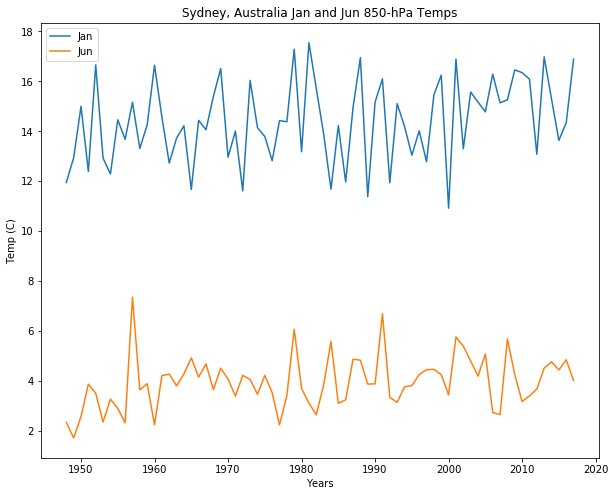

In [34]:
# Now let's plot stuff!
%matplotlib inline
import matplotlib.pyplot as plt

x = range(1948,1948+len(vtimes[::12]))
plt.figure(1,figsize=(10.,8.))
plt.plot(x,sydney_jan_850_temps, label='Jan')
plt.plot(x,sydney_jun_850_temps, label='Jun')
plt.ylabel('Temp (C)')
plt.xlabel('Years')
plt.legend()
plt.title('Sydney, Australia Jan and Jun 850-hPa Temps')
plt.show()
# Now you can make it better!

## Fun Exercise!

Let's compare the Sydney, Australia 850-hPa air temperatures with that over Chicago!

1. Find the index values for Chicago, IL USA (42N,-88E)
2. Grab the remote data for Chicago, IL air temperature
3. Slice the array to have only January 850-hPa air temperature for Chicago, IL
4. Plot both the Sydney and Chicago 850-hPa air temperatures on the same plot!